<a href="https://colab.research.google.com/github/bharshal/car_damage_detector/blob/master/part_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# for augmentations
!pip install albumentations==0.4.3

# for pretrained segmentation models fo PyTorch
!pip install segmentation-models-pytorch==0.1.0

# for TTA
!pip install ttach==0.0.2

# Catalyst itself
!pip install -U catalyst

# for tensorboard
!pip install tensorflow

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
!ls '/content/drive/My Drive/task_artivartic/dataset/'


damage_masks  part_masks  test	train  val


In [ ]:
DATA_DIR = '/content/drive/My Drive/task_artivartic/dataset/'
x_train_dir1 = os.path.join(DATA_DIR, 'train')
y_train_dir1 = os.path.join(DATA_DIR, 'part_masks')

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['a', 'b', 'c','d','e']
    
    def __init__(
            self, 
            array_images_dir, 
            array_masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_fps = []
        self.masks_fps = []
        for i, images_dir in enumerate(array_images_dir):
            masks_dir = array_masks_dir[i]
            for file_name in os.listdir(images_dir):
                if file_name.split(".")[1] == "jpg":
                  image = images_dir+"/"+file_name
                  mask = masks_dir+"/"+file_name.split('.')[0]+".npy"
                  #print(image)
                  #image = cv2.imread(image)
                  #print(image.shape)
                  self.images_fps.append(image)
                  self.masks_fps.append(mask)            

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        #print(self.images_fps[i])
        image = cv2.imread(self.images_fps[i])
        #print(image.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # print(self.masks_fps[i])
        mask = np.load(self.masks_fps[i])
        #mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation = cv2.INTER_AREA)
        mask = mask/255
        #print("shape"+str(np.array(mask).shape))
        
        # extract certain classes from mask (e.g. cars)
        # masks = [(mask == v) for v in self.class_values]
        # mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

In [ ]:
dataset = Dataset([x_train_dir1], [y_train_dir1], classes=['a','b','c','d','e'])

image, mask = dataset[12] # get some sample
print(image.shape)
print(mask.shape)


(1024, 1024, 3)
(1024, 1024, 5)


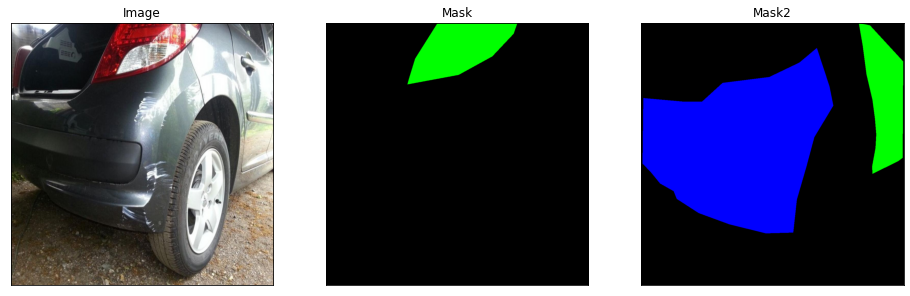

In [ ]:
visualize(
    image=image, 
    mask=mask[:,:,0:3].squeeze(),
    mask2=mask[:,:,2:].squeeze()
)

In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=100, min_width=100, always_apply=True, border_mode=0),
        albu.RandomCrop(height=900, width=1000, always_apply=False),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn, image_size=224):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Resize(image_size, image_size, p=1),
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


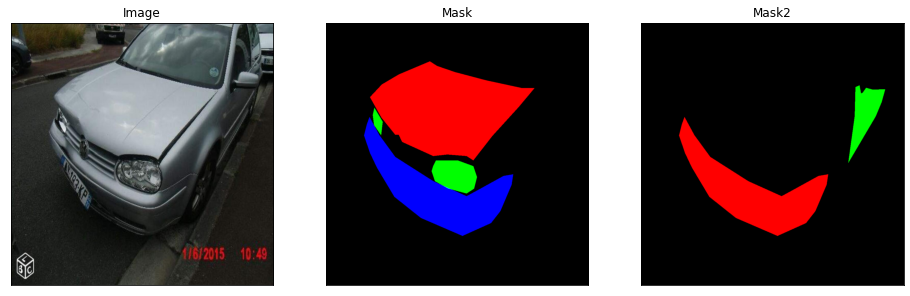

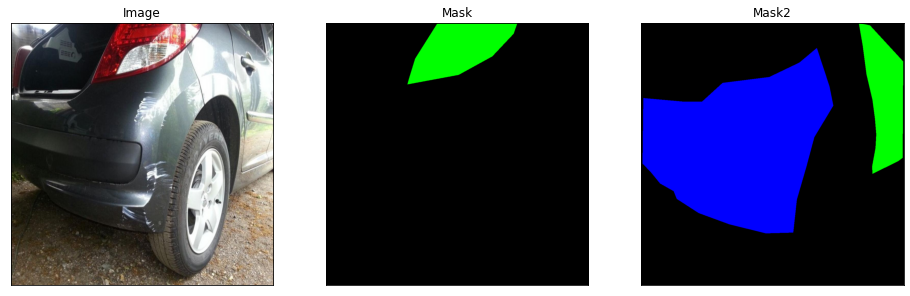

In [ ]:
augmented_dataset = Dataset([x_train_dir1], [y_train_dir1], classes=['a','b','c','d','e'])

# same image with different random transforms
for i in range(2):
    image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask[:,:,0:3], mask2=mask[:,:,2:])

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['a','b','c','d','e']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

model = smp.FPN(
    encoder_name=ENCODER,  
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
#model = torch.load("./drive/My Drive/TTball_weights/best_model.pth")
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
train_dataset = Dataset(
    [x_train_dir1], 
    [y_train_dir1],
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

image, mask = train_dataset[10]
print(image.shape)
print(mask.shape)
#visualize(image=image, mask=mask[:,:,1])


x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'part_masks/val')

valid_dataset = Dataset(
    [x_valid_dir], 
    [y_valid_dir], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=10)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


(3, 224, 224)
(5, 224, 224)


In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples

#model = torch.load('/content/drive/My Drive/task_artivartic/weights/segmentation_model.pth')
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
!mkdir '/content/drive/My Drive/task_artivartic/weights'
max_score = 0
#print(train_loader)
train_loss = []
val_loss = []
train_iou = []
val_iou = []

for i in range(0, 400):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_loss.append(train_logs['dice_loss'])
    val_loss.append(valid_logs['dice_loss'])
    train_iou.append(train_logs['iou_score'])
    val_iou.append(valid_logs['iou_score'])
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/drive/My Drive/task_artivartic/weights/part_seg.pth')
        print('Model saved!')
        
    if i == 150:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

print(train_loss)
print(val_loss)
print(train_iou)
print(val_iou)

In [ ]:
import pandas as pd
metrics = pd.DataFrame({
    "epoch":range(400),
    "train_loss":train_loss,
    "val_loss":val_loss,
    "train_iou":train_iou,
    "val_iou":val_iou
})

metrics.to_csv("parts_log.csv", sep=',', encoding='utf-8', index=False)

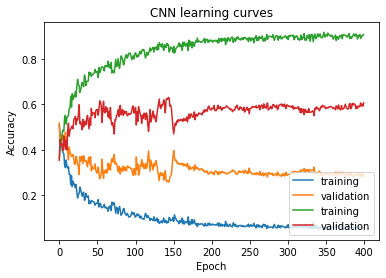

In [ ]:
import matplotlib.pyplot as plt

file = pd.read_csv('parts_log.csv')
lines = file.plot.line(x='epoch', y=['train_loss', 'val_loss', 'train_iou', 'val_iou'])
plt.title('CNN learning curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training', 'validation','training', 'validation'], loc='lower right')
plt.show()

In [ ]:
!ls '/content/drive/My Drive/task_artivartic/dataset/test'

11.jpg	12.jpg	28.jpg	45.jpg	60.jpg	66.jpg	67.jpg	72.jpg


/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


45.jpg
(224, 224, 5)


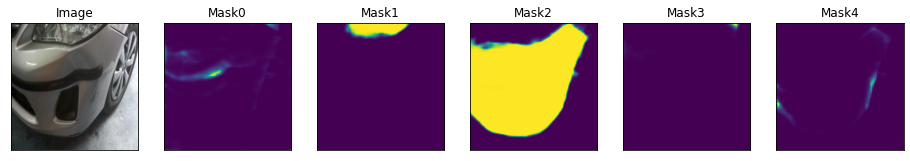

66.jpg
(224, 224, 5)


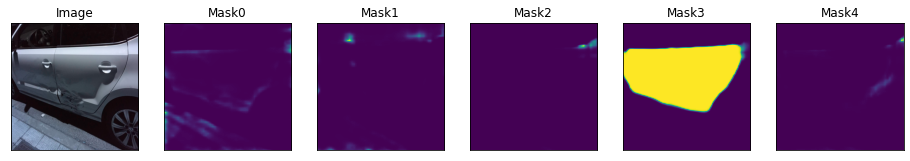

28.jpg
(224, 224, 5)


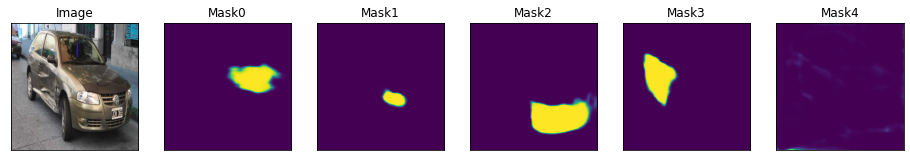

72.jpg
(224, 224, 5)


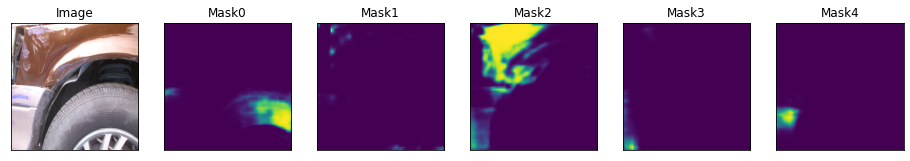

12.jpg
(224, 224, 5)


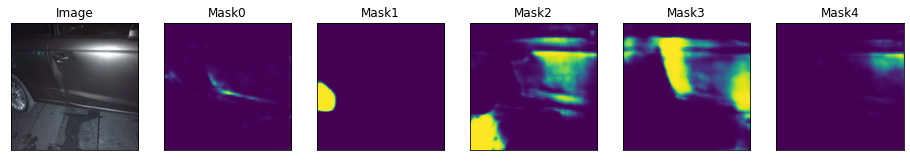

67.jpg
(224, 224, 5)


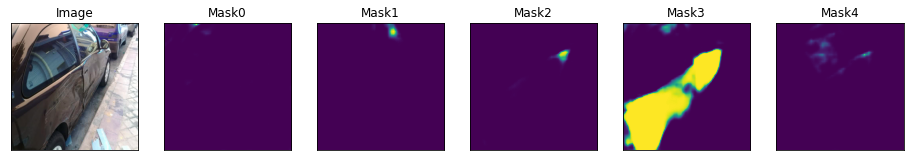

60.jpg
(224, 224, 5)


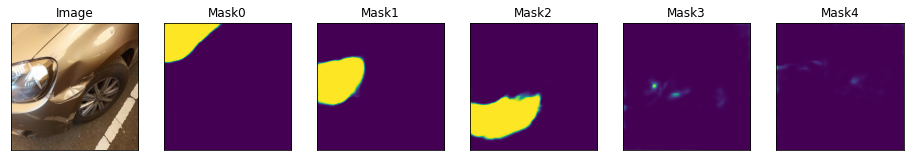

11.jpg
(224, 224, 5)


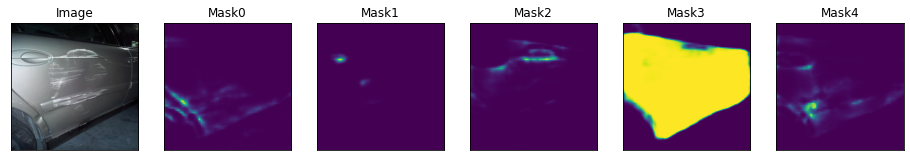

In [ ]:
import cv2 
import numpy as np 
 
model = torch.load('/content/drive/My Drive/task_artivartic/weights/part_seg.pth')

image_size = 224
_transform = [
      albu.Resize(image_size, image_size, p=1),
      albu.Lambda(image=preprocessing_fn),
      albu.Lambda(image=to_tensor),
  ]
trans = albu.Compose(_transform)
for file_name in os.listdir('/content/drive/My Drive/task_artivartic/dataset/test'):
  print(file_name)
  _frame = cv2.imread('/content/drive/My Drive/task_artivartic/dataset/test/'+str(file_name))
  frame = trans(image=_frame)
  abc  = torch.unsqueeze(torch.Tensor(frame["image"]), dim = 0)
  ans = model(abc.cuda())
  ans = ans.squeeze().cpu().detach().numpy()
  ans = np.transpose(ans, (1, 2, 0))
  ans = ans*255
  print(ans.shape)
  visualize(image=_frame, mask0=ans[:,:,0], mask1=ans[:,:,1], mask2=ans[:,:,2], mask3=ans[:,:,3], mask4=ans[:,:,4])